In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
### MOVIE DATABASES ###

# Box Office Mojo by IMDb Pro
movie_gross_df = pd.read_csv('../data/zippedData/bom.movie_gross.csv.gz')

# IMDb
imdb_name_df = pd.read_csv('../data/zippedData/imdb.name.basics.csv.gz')
imdb_akas_df = pd.read_csv('../data/zippedData/imdb.title.akas.csv.gz')
imdb_basics_df = pd.read_csv('../data/zippedData/imdb.title.basics.csv.gz')
imdb_crew_df = pd.read_csv('../data/zippedData/imdb.title.crew.csv.gz')
imdb_principals_df = pd.read_csv('../data/zippedData/imdb.title.principals.csv.gz')
imdb_ratings_df = pd.read_csv('../data/zippedData/imdb.title.ratings.csv.gz')

# Rotten Tomatos
rt_movies_df = pd.read_csv('../data/zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews_df = pd.read_csv('../data/zippedData/rt.reviews.tsv.gz', sep='\t', encoding= 'unicode_escape')

# The Movie Database
tmdb_movies_df = pd.read_csv('../data/zippedData/tmdb.movies.csv.gz')

# The Numbers
tn_budgets_df = pd.read_csv('../data/zippedData/tn.movie_budgets.csv.gz')

In [3]:
imdb_basics = imdb_basics_df
imdb_basics = imdb_basics.rename(columns = {'primary_title' : 'title'})
imdb_basics = imdb_basics.drop(['start_year'], axis =1)
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   title            146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   runtime_minutes  114405 non-null  float64
 4   genres           140736 non-null  object 
dtypes: float64(1), object(4)
memory usage: 5.6+ MB


In [4]:
imdb_basics.set_index('title')

,tconst,original_title,runtime_minutes,genres
title,,,,
Sunghursh,tt0063540,Sunghursh,175.0,"Action,Crime,Drama"
One Day Before the Rainy Season,tt0066787,Ashad Ka Ek Din,114.0,"Biography,Drama"
The Other Side of the Wind,tt0069049,The Other Side of the Wind,122.0,Drama
Sabse Bada Sukh,tt0069204,Sabse Bada Sukh,NaN,"Comedy,Drama"
The Wandering Soap Opera,tt0100275,La Telenovela Errante,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...
Kuambil Lagi Hatiku,tt9916538,Kuambil Lagi Hatiku,123.0,Drama
Rodolpho Teóphilo - O Legado de um Pioneiro,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,NaN,Documentary
Dankyavar Danka,tt9916706,Dankyavar Danka,NaN,Comedy


In [5]:
tn_budgets = tn_budgets_df
tn_budgets = tn_budgets.rename(columns = {'movie' : 'title'})
tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].str.replace("$","").str.replace(",","").astype(float)
tn_budgets['production_budget'] = tn_budgets['production_budget'].str.replace("$","").str.replace(",","").astype(float)
tn_budgets['profit'] = tn_budgets['worldwide_gross'] - tn_budgets['production_budget']
tn_budgets = tn_budgets.set_index('title')

In [6]:
tn_budgets.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,profit
title,,,,,,
Avatar,1,"Dec 18, 2009",425000000.0,"$760,507,625",2.776345e+09,2.351345e+09
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000.0,"$241,063,875",1.045664e+09,6.350639e+08
Dark Phoenix,3,"Jun 7, 2019",350000000.0,"$42,762,350",1.497624e+08,-2.002376e+08
Avengers: Age of Ultron,4,"May 1, 2015",330600000.0,"$459,005,868",1.403014e+09,1.072414e+09
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000.0,"$620,181,382",1.316722e+09,9.997217e+08


In [7]:
movie_gross_and_basics = imdb_basics.merge(tn_budgets, how = 'inner', on ='title')
movie_gross_and_basics = movie_gross_and_basics.drop_duplicates(subset = ['title'])

In [8]:
movie_gross_and_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312 entries, 0 to 3814
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             2312 non-null   object 
 1   title              2312 non-null   object 
 2   original_title     2312 non-null   object 
 3   runtime_minutes    2138 non-null   float64
 4   genres             2287 non-null   object 
 5   id                 2312 non-null   int64  
 6   release_date       2312 non-null   object 
 7   production_budget  2312 non-null   float64
 8   domestic_gross     2312 non-null   object 
 9   worldwide_gross    2312 non-null   float64
 10  profit             2312 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 216.8+ KB


In [9]:
movie_gross_and_basics = movie_gross_and_basics.sort_values(['profit'], ascending=False)
movie_gross_and_basics.head()

,tconst,title,original_title,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,profit
1747,tt1775309,Avatar,Abatâ,93.0,Horror,1,"Dec 18, 2009",425000000.0,"$760,507,625",2.776345e+09,2.351345e+09
2775,tt2495766,Titanic,Titanic,NaN,Adventure,43,"Dec 19, 1997",200000000.0,"$659,363,944",2.208208e+09,2.008208e+09
3360,tt4154756,Avengers: Infinity War,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",7,"Apr 27, 2018",300000000.0,"$678,815,482",2.048134e+09,1.748134e+09
12,tt0369610,Jurassic World,Jurassic World,124.0,"Action,Adventure,Sci-Fi",34,"Jun 12, 2015",215000000.0,"$652,270,625",1.648855e+09,1.433855e+09
2940,tt2820852,Furious 7,Furious Seven,137.0,"Action,Crime,Thriller",67,"Apr 3, 2015",190000000.0,"$353,007,020",1.518723e+09,1.328723e+09


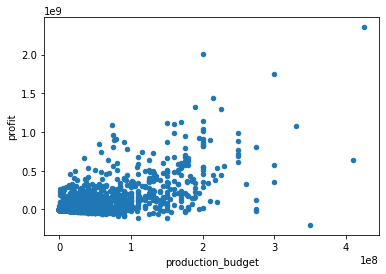

In [10]:
test1 = movie_gross_and_basics.corrwith(movie_gross_and_basics['profit'])**2
test1
movie_gross_and_basics.plot('production_budget', 'profit', kind = 'scatter');

In [11]:
imdb_name = imdb_name_df
imdb_name.sort_values(['primary_profession'])

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
293383,nm6193438,Kenta Maezawa,NaN,NaN,actor,"tt4326878,tt3443912,tt4308734,tt5300766"
212927,nm4325566,Aisha Bhiet,NaN,NaN,actor,tt1843853
450791,nm7493076,Rene Jester,NaN,NaN,actor,tt4908742
212930,nm4327256,Catalin Parvulescu,NaN,NaN,actor,"tt3356272,tt1727532"
553548,nm9347419,Joe Addo,NaN,NaN,actor,tt7497366
...,...,...,...,...,...,...
606611,nm9964778,Brian Espitia,NaN,NaN,NaN,NaN
606615,nm9967439,Jade Doucette,NaN,NaN,NaN,NaN
606618,nm9969939,Anna Bligh,NaN,NaN,NaN,tt8694294
606622,nm9976388,Naomie Monplaisir,NaN,NaN,NaN,tt7948406


In [12]:
imdb_crew = imdb_crew_df
imdb_crew.head()

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


In [13]:
imdb_crew = imdb_crew.merge(movie_gross_and_basics[['title', 'tconst']], on = 'tconst', how = 'left', validate = 'one_to_many')

In [14]:
imdb_crew = imdb_crew.dropna(subset = ['title'])

In [15]:
imdb_crew.set_index(['title'])

,tconst,directors,writers
title,,,
Straw Dogs,tt0999913,nm0527109,"nm0527109,nm0329051,nm0001603,nm0930684"
Love Ranch,tt1125929,nm0000431,nm0414893
Morning Glory,tt1126618,nm0585011,nm0112459
The Joneses,tt1152830,nm1864022,"nm1868973,nm1864022"
Rock of Ages,tt1336608,nm0788202,"nm0857620,nm0195476,nm1615610"
...,...,...,...
Counting,tt4462082,nm0169486,NaN
Marshall,tt5301662,nm0399737,"nm7817658,nm1105617"
Sgt. Stubby: An American Hero,tt5314190,nm4175844,"nm4175844,nm0831408"


In [16]:
imdb_ratings = imdb_ratings_df
imdb_ratings = imdb_ratings.merge(movie_gross_and_basics, on = 'tconst', how = 'left', validate = 'one_to_many')
imdb_ratings = imdb_ratings.dropna(subset = ['title']).sort_values('averagerating', ascending = False).drop(columns = ['original_title'], axis = 1)
imdb_ratings

,tconst,averagerating,numvotes,title,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,profit
68905,tt1455256,9.2,8,The Wall,78.0,Documentary,29.0,"May 12, 2017",3000000.0,"$1,803,064",4495262.0,1495262.0
21192,tt8680254,9.1,28,Richard III,NaN,Drama,65.0,"Dec 29, 1995",9200000.0,"$2,684,904",4199334.0,-5000666.0
36749,tt2316649,9.0,13,Frailty,NaN,Drama,95.0,"Apr 12, 2002",11000000.0,"$13,110,448",19947280.0,8947280.0
28061,tt1795369,9.0,1832,Frankenstein,130.0,Drama,3.0,"Nov 4, 1994",45000000.0,"$22,006,296",112006296.0,67006296.0
12597,tt2215463,9.0,45,Survivor,81.0,"Biography,Crime,Documentary",11.0,"May 29, 2015",20000000.0,$0,1703281.0,-18296719.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14173,tt2693114,2.3,104,Amnesiac,90.0,"Drama,Horror,Thriller",72.0,"Aug 14, 2015",3000000.0,$0,0.0,-3000000.0
41127,tt2149137,2.2,679,Snow White: A Deadly Summer,83.0,Horror,11.0,"Mar 20, 2012",1000000.0,$0,0.0,-1000000.0
29459,tt2814362,2.1,3878,United Passions,110.0,"Drama,History,Sport",6.0,"Jun 5, 2015",30000000.0,$918,168832.0,-29831168.0
57939,tt0249516,1.9,8248,Foodfight!,91.0,"Action,Animation,Comedy",26.0,"Dec 31, 2012",45000000.0,$0,73706.0,-44926294.0


In [17]:
imdb_ratings.corrwith(imdb_ratings['numvotes'])

averagerating        0.395439
numvotes             1.000000
runtime_minutes      0.435924
id                  -0.009726
production_budget    0.532644
worldwide_gross      0.589343
profit               0.561193
dtype: float64

In [18]:
writers = imdb_crew.assign(writers = lambda x :imdb_crew['writers'].str.split(','))

In [19]:
writers_profit = writers.explode('writers').merge(imdb_ratings, on = 'tconst', how = 'left', validate = 'many_to_one')

In [20]:
writers_profit['ROI'] = writers_profit['profit']/writers_profit['production_budget']

In [26]:
writers_profit.sort_values(['ROI'], ascending = False)

,tconst,directors,writers,title_x,averagerating,numvotes,title_y,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,profit,ROI
1854,tt2309260,"nm4000389,nm3951039",nm4000389,The Gallows,4.2,17763.0,The Gallows,81.0,"Horror,Mystery,Thriller",80.0,"Jul 10, 2015",100000.0,"$22,764,410",41656474.0,41556474.0,415.564740
1853,tt2309260,"nm4000389,nm3951039",nm3951039,The Gallows,4.2,17763.0,The Gallows,81.0,"Horror,Mystery,Thriller",80.0,"Jul 10, 2015",100000.0,"$22,764,410",41656474.0,41556474.0,415.564740
3035,tt2668120,nm0509852,nm0509852,Bambi,7.0,101.0,Bambi,58.0,"Biography,Documentary",47.0,"Aug 13, 1942",858000.0,"$102,797,000",268000000.0,267142000.0,311.354312
239,tt3080284,nm1126847,NaN,Rocky,6.1,46.0,Rocky,136.0,"Action,Comedy,Drama",11.0,"Nov 21, 1976",1000000.0,"$117,235,147",225000000.0,224000000.0,224.000000
1396,tt1560985,nm0068587,nm0068587,The Devil Inside,4.2,33522.0,The Devil Inside,83.0,Horror,12.0,"Jan 6, 2012",1000000.0,"$53,262,945",101759490.0,100759490.0,100.759490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,tt10313204,nm0004250,nm0004250,Father's Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5017,tt10313204,nm0004250,nm1880240,Father's Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5018,tt10313204,nm0004250,nm0005568,Father's Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5019,tt10332174,nm0794779,nm0794779,Nothing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
writers_profit.groupby(['writers']).sum('profit')

,averagerating,numvotes,runtime_minutes,id,production_budget,worldwide_gross,profit,ROI
writers,,,,,,,,
nm0000041,6.9,168514.0,132.0,55.0,90000000.0,1.625252e+08,7.252516e+07,0.805835
nm0000092,7.2,176699.0,98.0,26.0,135000000.0,5.730684e+08,4.380684e+08,3.244951
nm0000095,19.9,300442.0,308.0,175.0,54500000.0,2.114868e+08,1.569868e+08,8.457598
nm0000101,5.2,186788.0,116.0,4.0,144000000.0,2.290087e+08,8.500866e+07,0.590338
nm0000108,54.8,1313787.0,932.0,494.0,451000000.0,1.666388e+09,1.215388e+09,29.540840
...,...,...,...,...,...,...,...,...
nm9634718,6.1,1518.0,96.0,75.0,6840000.0,2.227300e+04,-6.817727e+06,-0.996744
nm9708167,5.7,67.0,106.0,47.0,500000.0,3.087930e+05,-1.912070e+05,-0.382414
nm9793762,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000


In [22]:
top_writers = writers_profit.groupby(['writers']).sum('profit').sort_values('profit', ascending = False)[:25]

In [23]:
top_writers

,averagerating,numvotes,runtime_minutes,id,production_budget,worldwide_gross,profit,ROI
writers,,,,,,,,
nm0456158,143.0,10079141.0,2550.0,860.0,3.983600e+09,1.544344e+10,1.145984e+10,57.786804
nm0498278,135.1,9260615.0,2416.0,923.0,3.708600e+09,1.470574e+10,1.099714e+10,56.280110
nm1293367,58.9,4473902.0,995.0,372.0,1.410000e+09,6.967595e+09,5.557595e+09,29.340881
nm0800209,45.8,3680718.0,830.0,153.0,1.365600e+09,6.556356e+09,5.190756e+09,21.510046
nm1321656,50.6,3447301.0,910.0,197.0,1.191000e+09,5.417240e+09,4.226240e+09,21.357986
nm1321655,50.6,3447301.0,910.0,197.0,1.191000e+09,5.417240e+09,4.226240e+09,21.357986
nm4160687,23.9,2284914.0,411.0,25.0,8.006000e+08,4.222016e+09,3.421416e+09,12.605470
nm0666791,33.3,1092211.0,464.0,155.0,3.580000e+08,3.628817e+09,3.270817e+09,44.322374
nm0202425,33.3,1092211.0,464.0,155.0,3.580000e+08,3.628817e+09,3.270817e+09,44.322374


In [24]:
writers_profit.value_counts('writers')[:25]

writers
nm0456158    20
nm0498278    19
nm0831557    10
nm0000108     9
nm1293367     8
nm0868219     8
nm1321656     7
nm2305431     7
nm1321655     7
nm0963359     7
nm0000636     7
nm0197855     6
nm1615610     6
nm0921013     6
nm0517589     6
nm0326246     6
nm0800209     6
nm0484907     6
nm0570912     6
nm0415425     6
nm0798646     6
nm0891216     6
nm0817023     6
nm3123612     6
nm0008743     6
dtype: int64